## Import Datasets and merge together into one dataset by key values 

In [29]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
from functools import reduce

epid = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv", parse_dates = True)
# deceased, deaths, recover etc
demo = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/demographics.csv")
# population
ind = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/index.csv")

eco = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/economy.csv")

geo = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/geography.csv")
# needed for country/country code/subregion1_code(city)


data = epid.merge(demo,on='key').merge(ind,on='key').merge(eco,on='key').merge(geo,on='key')

cases_per_1M = data['new_confirmed']/data['population'] # cases per 1 million pop
cases_per_1M = cases_per_1M.apply(lambda x: x*1000000)
data = data.assign(cases_per_1M = cases_per_1M)

## Summary and shape of our dataset

In [30]:
#data.describe()
#data.info()
data.head()
data.info
# number of days of observations we have for each country
num_days = data['date'].unique()
num_days.shape

(449,)

## Sampled dataset for the months of January and February 2021
This will now become our 'whole' dataset we will work with to do split sample validation

In [31]:
country_data = data[data['subregion1_code'].isnull()] # collect rows that don't specify subregions
country_data = country_data[(country_data['date'] >= '2021-01-01') & (country_data['date'] <= '2021-02-28')] # filter dates between jan and feb
country_data = country_data.drop(['subregion1_code','subregion1_name','subregion2_code','subregion2_name'], axis=1) # drop column
country_data.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 11921 entries, 367 to 111511
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         11921 non-null  object 
 1   key                          11862 non-null  object 
 2   new_confirmed                11921 non-null  float64
 3   new_deceased                 11921 non-null  float64
 4   new_recovered                910 non-null    float64
 5   new_tested                   5598 non-null   float64
 6   total_confirmed              11921 non-null  float64
 7   total_deceased               11921 non-null  float64
 8   total_recovered              829 non-null    float64
 9   total_tested                 5556 non-null   float64
 10  population                   11921 non-null  float64
 11  population_male              11862 non-null  float64
 12  population_female            11862 non-null  float64
 13  rural_populat

## Take the Sum and Mean of the columns in our dataset

In [32]:
country_data_sum = country_data.groupby( # grouping by country (takes into account all dates between jan and feb instead of by week)
   ['country_name']
).agg(
    {   'cases_per_1M': ['sum'], # sum of total new cases in the time span per 1M ppl
        'new_confirmed':['sum'],   # cumulative number of cases over the past 59 days 
        'population': ['mean'],
        'population_density': ['mean'],
        'new_deceased': ['sum'],
        'new_tested':	['sum'],
        'gdp_per_capita': ['mean']
    }
).reset_index()
# these numbers represent the entire 2 months we've filtered

conditions = [ # if else basically
    (country_data_sum['cases_per_1M'] < 500),
    (country_data_sum['cases_per_1M'] >= 500) & (country_data_sum['cases_per_1M'] < 1000),
    (country_data_sum['cases_per_1M'] >=  1000)
    ]
values = [1, 2, 3] # levels

country_data_sum['levels'] = np.select(conditions, values) # creates column for df

# similar to CDC, cases over january and february per 1M population put into levels

country_data_sum.info()

country_data_sum.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (country_name, )            203 non-null    object 
 1   (cases_per_1M, sum)         203 non-null    float64
 2   (new_confirmed, sum)        203 non-null    float64
 3   (population, mean)          203 non-null    float64
 4   (population_density, mean)  203 non-null    float64
 5   (new_deceased, sum)         203 non-null    float64
 6   (new_tested, sum)           203 non-null    float64
 7   (gdp_per_capita, mean)      203 non-null    int64  
 8   (levels, )                  203 non-null    int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 14.4+ KB


,country_name,cases_per_1M,new_confirmed,population,population_density,new_deceased,new_tested,gdp_per_capita,levels
,,sum,sum,mean,mean,sum,sum,mean,
0,Afghanistan,81.50874,3173.00000,38928341.00000,59627.00000,235.00000,0.00000,502,1
1,Albania,17191.00609,49208.00000,2862427.00000,99.60000,630.00000,197779.00000,5352,3
2,Algeria,311.16706,13645.00000,43851043.00000,18411.00000,231.00000,0.00000,3948,1
3,American Samoa,0.00000,0.00000,55196.00000,275985.00000,0.00000,0.00000,11466,1
4,Andorra,35876.52883,2772.00000,77265.00000,164394.00000,26.00000,0.00000,40886,3


## Now let's take a look at the correlation matrix of all variables in the data subset we are working with to see if we have a problem with multicollinearity
Since the Pearson method relies on the assumption of the data being normally distributed, we use the Spearman method instead because it doesn't have assumptions of the population distribution of the data, so it generalizes to our dataset better. 

In [33]:
corrMatrix = country_data_sum.corr(method = 'spearman')
print(corrMatrix)

                        cases_per_1M new_confirmed  ... gdp_per_capita   levels
                                 sum           sum  ...           mean         
cases_per_1M       sum       1.00000       0.68459  ...        0.53497  0.87007
new_confirmed      sum       0.68459       1.00000  ...        0.19103  0.63337
population         mean     -0.04343       0.62427  ...       -0.30542 -0.05767
population_density mean     -0.27441      -0.28965  ...       -0.18718 -0.21855
new_deceased       sum       0.64740       0.96129  ...        0.13175  0.61208
new_tested         sum       0.43633       0.72041  ...        0.27630  0.40153
gdp_per_capita     mean      0.53497       0.19103  ...        1.00000  0.48108
levels                       0.87007       0.63337  ...        0.48108  1.00000

[8 rows x 8 columns]


## Visualize the correlation matrix with a heatmap

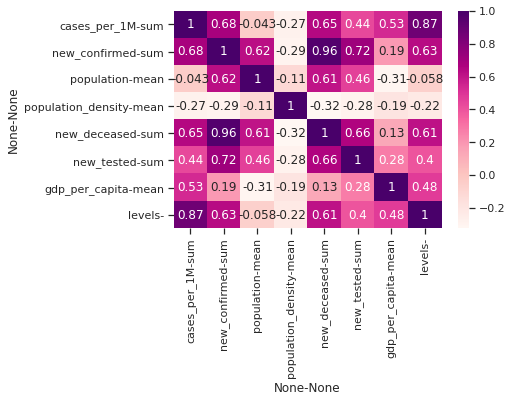

In [34]:
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(corrMatrix, annot = True, cmap = 'RdPu')
plt.show()

                               cases_per_1M  ...          levels
                                        sum  ...                
cases_per_1M       sum       91464663.66957  ...      5153.35649
new_confirmed      sum     1519273970.73054  ...    106645.80030
population         mean -107966861368.35056  ... -11416984.53856
population_density mean    1526982320.15915  ...   -120975.65737
new_deceased       sum       30710135.61300  ...      2548.72007
new_tested         sum    14305899475.46707  ...    990099.75708
gdp_per_capita     mean      84360304.20629  ...      6749.37629
levels                           5153.35649  ...         0.89616

[8 rows x 8 columns]


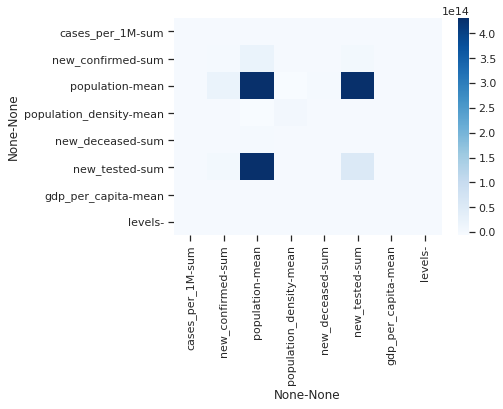

In [35]:
import seaborn as sn
import matplotlib.pyplot as plt
covMatrix = pd.DataFrame.cov(country_data_sum)
print(covMatrix)
sn.heatmap(covMatrix, annot = False, cmap = 'Blues', robust = True)
plt.show()

## Sampled dataset for the months of January and February 2021

In [36]:
country_data = data[data['subregion1_code'].isnull()] # collect rows that don't specify subregions
country_data = country_data[(country_data['date'] >= '2021-01-01') & (country_data['date'] <= '2021-02-28')] # filter dates between jan and feb
country_data = country_data.drop(['subregion1_code','subregion1_name','subregion2_code','subregion2_name'], axis=1) # drop column
country_data.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 11921 entries, 367 to 111511
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         11921 non-null  object 
 1   key                          11862 non-null  object 
 2   new_confirmed                11921 non-null  float64
 3   new_deceased                 11921 non-null  float64
 4   new_recovered                910 non-null    float64
 5   new_tested                   5598 non-null   float64
 6   total_confirmed              11921 non-null  float64
 7   total_deceased               11921 non-null  float64
 8   total_recovered              829 non-null    float64
 9   total_tested                 5556 non-null   float64
 10  population                   11921 non-null  float64
 11  population_male              11862 non-null  float64
 12  population_female            11862 non-null  float64
 13  rural_populat

## Split into Months
Using January data as our training set, and February data as our test set.

In [37]:
jan_data = country_data[(country_data['date'] >= '2021-01-01') & (country_data['date'] < '2021-02-01')]

jan_data = jan_data.groupby(
   ['country_name']
).agg(
    {   'cases_per_1M': ['sum'], # sum of total new cases in the time span per 1M ppl
        'new_confirmed':['sum'],   # cumulative number of cases over the past 59 days 
        'population': ['mean'],
        'population_density': ['mean'],
        'new_deceased': ['sum'],
        'new_tested':	['sum'],
        'gdp_per_capita': ['mean']
    }
).reset_index()



conditions = [  # if else basically
    (jan_data['cases_per_1M'] < 500), # level 1
    (jan_data['cases_per_1M'] >= 500) & (jan_data['cases_per_1M'] < 1000), # level 2
    (jan_data['cases_per_1M'] >=  1000) # level 3
    ]
values = [1, 2, 3]

## true labels for our training data
jan_data['levels'] = np.select(conditions, values)

jan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (country_name, )            203 non-null    object 
 1   (cases_per_1M, sum)         203 non-null    float64
 2   (new_confirmed, sum)        203 non-null    float64
 3   (population, mean)          203 non-null    float64
 4   (population_density, mean)  203 non-null    float64
 5   (new_deceased, sum)         203 non-null    float64
 6   (new_tested, sum)           203 non-null    float64
 7   (gdp_per_capita, mean)      203 non-null    int64  
 8   (levels, )                  203 non-null    int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 14.4+ KB


In [38]:
jan_data = jan_data.set_index(['country_name'])

In [39]:
feb_data = country_data[(country_data['date'] >= '2021-02-01') & (country_data['date'] <= '2021-02-28')]

feb_data = feb_data.groupby(
   ['country_name']
).agg(
    {   'cases_per_1M': ['sum'], # sum of total new cases in the time span per 1M ppl
        'new_confirmed':['sum'],   # cumulative number of cases over the past 59 days 
        'population': ['mean'],
        'population_density': ['mean'],
        'new_deceased': ['sum'],
        'new_tested':	['sum'],
        'gdp_per_capita': ['mean']
    }
).reset_index()


conditions = [  # if else basically
    (feb_data['cases_per_1M'] < 500), # level 1
    (feb_data['cases_per_1M'] >= 500) & (feb_data['cases_per_1M'] < 1000), # level 2
    (feb_data['cases_per_1M'] >=  1000) # level 3
    ]
values = [1, 2, 3]

## true labels for our testing data 
feb_data['levels'] = np.select(conditions, values)

feb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (country_name, )            202 non-null    object 
 1   (cases_per_1M, sum)         202 non-null    float64
 2   (new_confirmed, sum)        202 non-null    float64
 3   (population, mean)          202 non-null    float64
 4   (population_density, mean)  202 non-null    float64
 5   (new_deceased, sum)         202 non-null    float64
 6   (new_tested, sum)           202 non-null    float64
 7   (gdp_per_capita, mean)      202 non-null    int64  
 8   (levels, )                  202 non-null    int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 14.3+ KB


In [40]:
feb_data = feb_data.set_index(['country_name'])

## Construct our Response Variable: Each countries labels (overall for january and february)

In [41]:
response_var = country_data_sum[['levels']].copy() # new dataframe containing only the 'levels' column, indexed by country 
response_var

,levels
,
0,1
1,3
2,1
3,1
4,3
...,...
198,1
199,1
200,1


In [42]:
response_var.value_counts()

(levels, )
3             118
1              73
2              12
dtype: int64

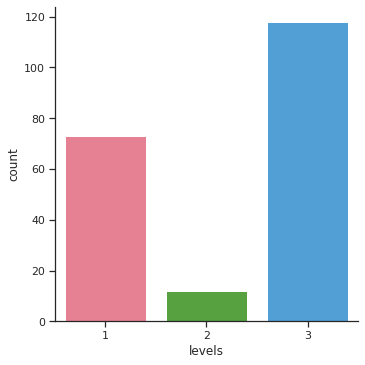

In [43]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.color_palette("husl", 3)
g = sns.catplot(x = "levels", kind = "count", palette = "husl", data = response_var, order = [1, 2, 3])

We can see that the classes are severity imbalanced, with level 2 being the minority class

## Training set

In [44]:



train_X = jan_data.drop(['levels'], axis = 1)
train_X['population_density'].fillna((feb_data['population_density'].mean()), inplace=True)
train_X

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,cases_per_1M,new_confirmed,population,population_density,new_deceased,new_tested,gdp_per_capita
,sum,sum,mean,mean,sum,sum,mean
country_name,,,,,,,
Afghanistan,65.11965,2535.00000,38928341.00000,59627.00000,194.00000,0.00000,502
Albania,7081.05394,20269.00000,2862427.00000,99.60000,207.00000,96685.00000,5352
Algeria,181.70605,7968.00000,43851043.00000,18411.00000,138.00000,0.00000,3948
American Samoa,0.00000,0.00000,55196.00000,275985.00000,0.00000,0.00000,11466
Andorra,24008.28318,1855.00000,77265.00000,164394.00000,17.00000,0.00000,40886
...,...,...,...,...,...,...,...
Vanuatu,0.00000,0.00000,307150.00000,25197.00000,0.00000,0.00000,3058
Vietnam,3.87308,377.00000,97338583.00000,313925.00000,0.00000,0.00000,2715


In [45]:
train_Y = jan_data['levels']
train_Y

country_name
Afghanistan       1
Albania           3
Algeria           1
American Samoa    1
Andorra           3
                 ..
Vanuatu           1
Vietnam           1
Yemen             1
Zambia            3
Zimbabwe          3
Name: levels, Length: 203, dtype: int64

## Testing Set

In [46]:
import statistics

test_X = feb_data.drop(['levels'],axis = 1).fillna(0)
test_X['population_density'].fillna((feb_data['population_density'].mean()), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [47]:
test_Y = feb_data['levels']
test_Y

country_name
Afghanistan       1
Albania           3
Algeria           1
American Samoa    1
Andorra           3
                 ..
Vanuatu           1
Vietnam           1
Yemen             1
Zambia            3
Zimbabwe          1
Name: levels, Length: 202, dtype: int64

In [48]:
print('Training Set Shape:')
print('Features:', train_X.shape)
print('True Class Levels:', train_Y.shape)
print('Testing Set Shape:')
print('Features', test_X.shape)
print('True Class Levels:', test_Y.shape)

Training Set Shape:
Features: (203, 7)
True Class Levels: (203,)
Testing Set Shape:
Features (202, 7)
True Class Levels: (202,)


## Oversampling

Since there is class imbalance especially among level 2, we use the SMOTEEN package to oversample.

In [49]:
from collections import Counter
from imblearn.combine import SMOTEENN

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


length of oversampled data is  318
Number of countries level 1 in oversampled data 106
Number of countries level 2 in oversampled data 106
Number of countries level 3 in oversampled data 106


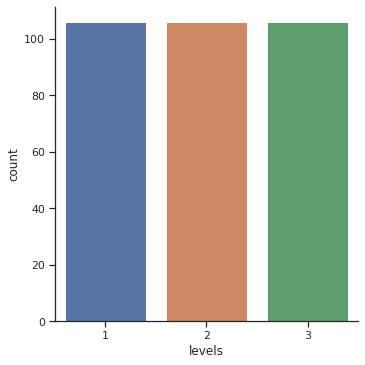

In [50]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
columns = train_X.columns
os_data_X,os_data_y=os.fit_sample(train_X, train_Y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y = pd.DataFrame(data=os_data_y,columns=['levels'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of countries level 1 in oversampled data",len(os_data_y[os_data_y['levels']==1]))
print("Number of countries level 2 in oversampled data",len(os_data_y[os_data_y['levels']==2]))
print("Number of countries level 3 in oversampled data",len(os_data_y[os_data_y['levels']==3]))
sns.set_theme(style="ticks")
sns.color_palette("husl", 3)

y_os = sns.catplot(x = "levels", kind = "count", data = os_data_y, order = [1, 2, 3])

## OVR Logistic Regression

Regular Logistic Regression is for binary responses which is why we opt for different variants of logistic regression for multi-classification.



In [51]:
from sklearn.linear_model import LogisticRegression
logmod_ovr = LogisticRegression(multi_class='ovr').fit(os_data_X, os_data_y.values.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [52]:
print(logmod_ovr.score(test_X, test_Y)) # accuracy

0.9702970297029703


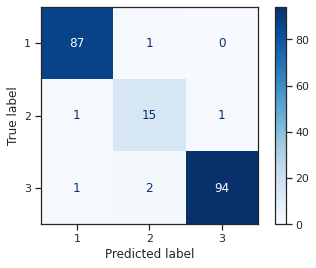

In [53]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


levels = ['1','2','3']
ovrdisp = plot_confusion_matrix(logmod_ovr, test_X, test_Y,
                                 display_labels=levels,
                                 cmap=plt.cm.Blues)
plt.show()

In [54]:
import sklearn.metrics as metrics
import plotly.figure_factory as ff
print(metrics.classification_report(test_Y, logmod_ovr.predict(test_X))) # classification report



              precision    recall  f1-score   support

           1       0.98      0.99      0.98        88
           2       0.83      0.88      0.86        17
           3       0.99      0.97      0.98        97

    accuracy                           0.97       202
   macro avg       0.93      0.95      0.94       202
weighted avg       0.97      0.97      0.97       202



## Multinomial Logistic Regression

In [55]:
logmod_multi = LogisticRegression(multi_class='multinomial',
    solver='lbfgs').fit(os_data_X, os_data_y.values.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [56]:
logmod_multi.score(test_X, test_Y)


0.7574257425742574

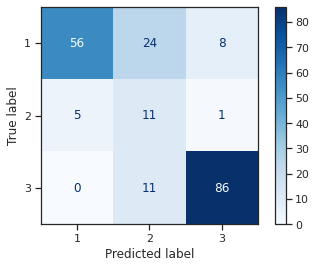

In [57]:
multidisp = plot_confusion_matrix(logmod_multi, test_X, test_Y,
                                 display_labels=levels,
                                 cmap=plt.cm.Blues)
plt.show()

In [58]:
print(metrics.classification_report(test_Y, logmod_multi.predict(test_X)))# classification report



              precision    recall  f1-score   support

           1       0.92      0.64      0.75        88
           2       0.24      0.65      0.35        17
           3       0.91      0.89      0.90        97

    accuracy                           0.76       202
   macro avg       0.69      0.72      0.67       202
weighted avg       0.85      0.76      0.79       202



## Ordinal Logistic Regression

In [59]:
!pip install mord
from mord import LogisticAT
ord = LogisticAT(alpha=0)
ord.fit(os_data_X,os_data_y.values.ravel())
ord_y = ord.predict(test_X)
print((metrics.accuracy_score(test_Y, np.round(ord_y)))) # accuracy


  Created wheel for mord: filename=mord-0.6-cp37-none-any.whl size=6007 sha256=4d530b6dcf4cb8936f432c7c35b49e7fa36da7bcbbcf8d754d6349c5b6368655
  Stored in directory: /root/.cache/pip/wheels/98/14/b2/244c2cec93a0c6edb29b488bd6b2710ded7e9d457033b86366
Successfully built mord
0.9207920792079208


In [60]:
metrics.confusion_matrix(test_Y,ord_y) # confusion matrix

array([[83,  5,  0],
       [ 3,  7,  7],
       [ 1,  0, 96]])

In [61]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_Y, ord.predict_proba(test_X), multi_class = 'ovr')

0.9454971234897666

In [62]:
print(metrics.classification_report(test_Y, ord.predict(test_X))) # classification report

              precision    recall  f1-score   support

           1       0.95      0.94      0.95        88
           2       0.58      0.41      0.48        17
           3       0.93      0.99      0.96        97

    accuracy                           0.92       202
   macro avg       0.82      0.78      0.80       202
weighted avg       0.91      0.92      0.91       202



## Multiclass Logistic Regression with Built in Cross Validation
We use the L-2 Ridge Penalty and 10-fold Cross Validation: this model gives the best accuracy out of all of them at 97.4%

In [63]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
clf = LogisticRegressionCV(cv = 10, random_state = 0, penalty = 'l2', solver = 'newton-cg', max_iter = 1000)
clf.fit(os_data_X, os_data_y.values.ravel())
clf_pred = clf.predict(test_X)
print(accuracy_score(test_Y, clf_pred))

0.9554455445544554


In [64]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_Y, clf.predict_proba(test_X), multi_class = 'ovr')

0.9801550553423698

In [65]:
print(metrics.classification_report(test_Y, clf_pred)) # classification report

              precision    recall  f1-score   support

           1       0.99      1.00      0.99        88
           2       0.70      0.94      0.80        17
           3       0.99      0.92      0.95        97

    accuracy                           0.96       202
   macro avg       0.89      0.95      0.92       202
weighted avg       0.96      0.96      0.96       202



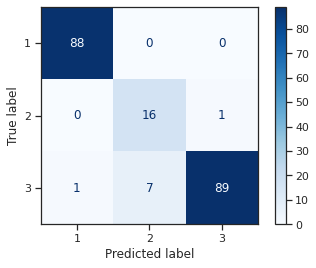

In [66]:
logcv_disp = plot_confusion_matrix(clf, test_X, test_Y,
                                 display_labels=levels,
                                 cmap=plt.cm.Blues)
plt.show()

## Model Selection/Conclusion

Out of all the logistic regression variants we have tried, the best accuracy, classification matrix, and classification report is OVR and the multiclass logistic regression with cross validation model. These two are pretty close in performs with OVR having the better classification report and logistic regression CV having the better confusion matrix.

In [89]:
print('OVR Logistic Regression Accuracy:', np.round(logmod_ovr.score(test_X, test_Y)*100))
print('Multinomial Logistic Regression Accuracy:', np.round(logmod_multi.score(test_X, test_Y)*100))
print('Ordinal Logistic Regression Accuracy:', np.round(metrics.accuracy_score(test_Y, np.round(ord_y))*100))
print('Multiclass Logistic Regression CV Accuracy:', np.round(accuracy_score(test_Y, clf_pred)*100))

OVR Logistic Regression Accuracy: 97.0
Multinomial Logistic Regression Accuracy: 76.0
Ordinal Logistic Regression Accuracy: 92.0
Multiclass Logistic Regression CV Accuracy: 96.0
